In [3]:
import pandas as pd
pd.options.display.max_colwidth = 800
pd.options.display.max_rows = 200
pd.options.display.max_columns = 100
reviews_df = pd.read_excel('../datasets/Reviews_more.xlsx')

In [4]:
"""
1.) 4 aspects (closed)
2.) Convert comment to English as data augmentation(if needed)
3.) Opnion|General|Comfort|Sound|Battery|


1.这里我们的一个sample其实只包括一个句子和一个aspect。我們假設一個句子中不同aspects不會相互干擾


Case1: Aspect is in text(closed)
Case2: Aspect is not in text(open)

Paper的Dataset目前是屬於case1.

How to infer a comment?
Let's say input comment is

Washable pillows and headbands, and microphone as well as remote control and an okay sound for only SEK 250. 
They go off if you make a quick throw forward with your head, and they squeeze a little hard on the glasses.

Way1: Given an aspect(Only one aspect at one time and it has to be in the text) --> case1

Way2: Given an aspect(any aspect but given aspects such as 
    1.General 
    2.Comfort 
    3.Sound 
    4.Battery


Q1:等下確認他有用到aspect in index 的資訊在input嗎？ 
A1: 沒有

Pain Point:
現在的model沒有aspect extraction, 你要決定這是哪一個aspect(且這個aspect要在句子中)
"""
# 4 aspects (closed)
reviews_df

,Omdöme,Generell,Komfort,Ljud,Batteri
0,"Tvättbara kuddar och huvudband, och mikrofon samt fjärrkontroll och ett okej ljud för bara 250 kronor. De åker av om man gör ett hastigt kast framåt med huvudet, och de klämmer lite hårt på glasögonen.",NaN,Negativ,Positiv,NaN
1,Eftersom jag lyssnar mest på klassisk musik testade jag hörlurarna på Brahms klarinett trio med Martin Fröst och tyckte det lät mycket bra. Lurarna är lätta och verkar också isolera bra från störande ljud i omgivningen.,NaN,Positiv,Positiv,NaN
2,"Köpte dessa Sonys för att använda i hemmastudio. De är välbyggda, kvalitativa och sköna att ha på sig - ljudet är förstås mycket bra och ""platt"". Bra för mixing and mastering. Rekommenderas!",Positiv,Positiv,Positiv,NaN
3,"Har flera vänner som äger dessa klassiker, och som pratade sig varma om hur bra de är i relation till priset. Köpte dessa för att ha som hörlurar i hemmastudion, men använder de allt mer även till vardags. Skärmar omgivande ljud bra, ger en balanserad ljudbild och kan bäras utan problem en hel dag.",Positiv,Positiv,Positiv,NaN
4,Klassiska slutna och robusta studiohörlurar. Går bra att mix i. Billagare alternativ till de mer väljudande DT-770.,Positiv,NaN,NaN,NaN
...,...,...,...,...,...
924,"Efter att ha läst några andra recensioner som säger att dem är ömtåliga så tror jag att jag motsatsen till ett måndagsexemplar. Dem har tagit så sjukt mycket stryk från att ha ramlat ner från skrivbordet säkert 30-40 gånger, blivit avslängda i ilska av undertecknad.",NaN,NaN,NaN,NaN
925,Bästa gamingheadsetet jag nånsin ägt jätte skön att ha på sig och man skulle säkert kunna ha på sig den 24 timmar utan att få ont i öronen,Positiv,Positiv,NaN,NaN
926,"Jag såg en recension från Hardware Canucks på youtube om detta headset, vilket gav mig rätt bra vibbar om det här headsetet.",NaN,NaN,NaN,NaN
927,"Hörlurarna sitter riktigt bra på huvudet, goda inställningsmöjligheter och relativt bra ljud! Dock har jag erfarat lite småproblem när jag kört dom via USB, så nu kör jag dom via 3,5mm jack - emulerad 7.1 är överskattat ändå.",NaN,Positiv,Positiv,NaN


In [5]:
# 現在要怎麼準備training data? 
# way1: aspect就給死($T$ 放在句子中的哪裡會較合理), 但他不一定會在text, 硬train一發(反正for bert_spc or aspect_bert_indices 看起來都沒有用aspect in index information)
# 先把fixed aspect都放在句子最後面硬train
# way2: 要human標出具體的aspect, 這個aspect有出現在句字中, paper中的model現在是支援
# Given a context sequence wc = {w1c , w2c , ..., wnc } and a target sequence wt = {w1t , w2t , ..., wmt }, 
# where wt is a sub-sequence of wc. 
# The goal of this model is to predict the sentiment polarity of the sentence wc over the target wt.(wt必須sub-sequence)

# reviews_df label analysis

In [6]:
reviews_df.Ljud.value_counts(dropna=False)

Positiv    447
NaN        385
Negativ     97
Name: Ljud, dtype: int64

In [7]:
reviews_df.Komfort.value_counts(dropna=False)

NaN        615
Positiv    255
Negativ     59
Name: Komfort, dtype: int64

In [8]:
reviews_df.Generell.value_counts(dropna=False)

NaN        539
Positiv    292
Negativ     98
Name: Generell, dtype: int64

In [9]:
reviews_df[reviews_df.Generell.isnull()].sample(5)

,Omdöme,Generell,Komfort,Ljud,Batteri
114,Bra Bose-igt ljud och komfort. Jag tål inte in-earlurar som dels förstärker fotstampet och dels stänger ute allt ljud.,NaN,Positiv,Positiv,NaN
94,"Priset kanske är lite högt men när konkurrenterna med något sämre produkter har samma priser så kanske man får vara nöjd. Har använt dessa intensivt nu i ca 2 veckor och är lyrisk. Bekväma, inte för varma, jättebra brusreducering, precis lagom.",NaN,Positiv,NaN,NaN
411,"+ Ljudet var bra, rätt trevlig bas. Bekväma. Mic'en är lätt att ta fram/gömma. Har inget att jämföra med, men räckvidden kändes ok (2 betongväggar + minst 5-10 m avstånd iaf)\n\n- Väldigt plastiga, knakar rätt mycket.",NaN,Positiv,Positiv,NaN
751,Köpte dessa lurar pga att de rekommenderats på hemsidan här. Bra köp tänkte jag. Inte alls så bra köp visade det sig. Finns i stort sett ingen bas alls i dem och ljuden är minst sagt mediokert. Mitt tips; prova ett par andra istället.,NaN,NaN,Negativ,NaN
671,"Present till en 10 årig gamer. Bra kavalitet, superbra ljud och väldigt mjuka och sköna på öronen. Stänger ute väldigt mkt ljud ðð½ kan användas till många konsoler och dator samt mobil/padda.",NaN,Positiv,Positiv,NaN


In [10]:
reviews_df[reviews_df.Generell=="Negativ"].sample(5)

,Omdöme,Generell,Komfort,Ljud,Batteri
902,"Köpt dessa i torsdags, har provat dom 2 gånger under en promenad och ett träningspass på gym.\nUnder promenaden pratade jag i telefonen och motparten hörde snön under skorna o större sig på ljudkvalitén. Under samtalet klippte det konstant.",Negativ,NaN,Negativ,NaN
21,VARNING. Om man inte är försiktig när man tar ut hörlurarna kan silicon buden fastna långt in i örat. Dem har gjort det för mig två gånger nu. De kan fastna väldigt långt in och det är både farligt och obehagligt. Jag vågar inte använda dem längre tyvärr..,Negativ,NaN,NaN,NaN
437,The g933 has amazing sound but that is the about the only good thing this headset offers you!,Negativ,NaN,Positiv,NaN
404,"Har tidigare haft Logitech G930 som jag var jättenöjd med, köpte G933 Augusti 2016 och har haft blandade erfarenheter med dessa. Efter några månaders användning började headset:et tappa anslutningen till USB-recievern så jag fick återställa anslutningen varje gång batteriet tagit slut.",Negativ,NaN,NaN,NaN
625,Köpte detta headset för 1 månad sedan. Och efter en vecka började kontakten lagga. Tillslut funkade inte högra örat. Har nästan inte använt den alls. Ren skit. Inte värt pengarna. Bara plast...,Negativ,NaN,Negativ,NaN


In [11]:
reviews_df[reviews_df.Generell=="Positiv"].sample(5)

,Omdöme,Generell,Komfort,Ljud,Batteri
448,har nu haft g933 i en månad och måste säga att jag är väldigt nöjd! ibörjan satt jag och skrek då det kan koppla ifrån!,Positiv,NaN,NaN,NaN
47,Otroligt nöjd med dessa lurar! :) Väldig kvalitetskänsla och bra ljud. Batteriet verkar typ aldrig ta slut. Mycket bra!,Positiv,NaN,Positiv,Positiv
261,Super bra produkt med bra passform .Rekommenderas till alla,Positiv,Positiv,NaN,NaN
168,"Har varit ett fan av Sennheisers in ear en längre tid, men ville ha några sköna lurar att kunna ta med på resor och även hemma vid tvn, så jag googlade lite och dessa hade fått topp betyg och jag är verkligen INTE besviken!\nSennheiser levererar åter igen",Positiv,NaN,NaN,NaN
672,Jag tycker att denna produkt är bra för att ha till att spela med men även med att prata med andra var lite problem i början men det löste sig snabbt,Positiv,NaN,NaN,NaN


# prepare training data

In [12]:
reviews_df.columns.tolist()

['Omdöme', 'Generell', 'Komfort', 'Ljud', 'Batteri']

In [28]:
# pre-proceesing
reviews_df.fillna(0, inplace = True) # neutral
# Generell
reviews_df.Generell = reviews_df.Generell.apply(lambda x: 1 if x == "Positiv" else x) 
reviews_df.Generell = reviews_df.Generell.apply(lambda x: -1 if x == "Negativ" else x) 
# Komfort
reviews_df.Komfort = reviews_df.Komfort.apply(lambda x: 1 if x == "Positiv" else x) 
reviews_df.Komfort = reviews_df.Komfort.apply(lambda x: -1 if x == "Negativ" else x) 

# Ljud
reviews_df.Ljud = reviews_df.Ljud.apply(lambda x: 1 if x == "Positiv" else x) 
reviews_df.Ljud = reviews_df.Ljud.apply(lambda x: -1 if x == "Negativ" else x) 

# Batteri
reviews_df.Batteri = reviews_df.Batteri.apply(lambda x: 1 if x == "Positiv" else x) 
reviews_df.Batteri = reviews_df.Batteri.apply(lambda x: -1 if x == "Negativ" else x) 

reviews_df

,Omdöme,Generell,Komfort,Ljud,Batteri
0,"Tvättbara kuddar och huvudband, och mikrofon samt fjärrkontroll och ett okej ljud för bara 250 kronor. De åker av om man gör ett hastigt kast framåt med huvudet, och de klämmer lite hårt på glasögonen.",0,-1,1,0
1,Eftersom jag lyssnar mest på klassisk musik testade jag hörlurarna på Brahms klarinett trio med Martin Fröst och tyckte det lät mycket bra. Lurarna är lätta och verkar också isolera bra från störande ljud i omgivningen.,0,1,1,0
2,"Köpte dessa Sonys för att använda i hemmastudio. De är välbyggda, kvalitativa och sköna att ha på sig - ljudet är förstås mycket bra och ""platt"". Bra för mixing and mastering. Rekommenderas!",1,1,1,0
3,"Har flera vänner som äger dessa klassiker, och som pratade sig varma om hur bra de är i relation till priset. Köpte dessa för att ha som hörlurar i hemmastudion, men använder de allt mer även till vardags. Skärmar omgivande ljud bra, ger en balanserad ljudbild och kan bäras utan problem en hel dag.",1,1,1,0
4,Klassiska slutna och robusta studiohörlurar. Går bra att mix i. Billagare alternativ till de mer väljudande DT-770.,1,0,0,0
...,...,...,...,...,...
924,"Efter att ha läst några andra recensioner som säger att dem är ömtåliga så tror jag att jag motsatsen till ett måndagsexemplar. Dem har tagit så sjukt mycket stryk från att ha ramlat ner från skrivbordet säkert 30-40 gånger, blivit avslängda i ilska av undertecknad.",0,0,0,0
925,Bästa gamingheadsetet jag nånsin ägt jätte skön att ha på sig och man skulle säkert kunna ha på sig den 24 timmar utan att få ont i öronen,1,1,0,0
926,"Jag såg en recension från Hardware Canucks på youtube om detta headset, vilket gav mig rätt bra vibbar om det här headsetet.",0,0,0,0
927,"Hörlurarna sitter riktigt bra på huvudet, goda inställningsmöjligheter och relativt bra ljud! Dock har jag erfarat lite småproblem när jag kört dom via USB, så nu kör jag dom via 3,5mm jack - emulerad 7.1 är överskattat ändå.",0,1,1,0


In [29]:
d = {"A":1}
d.update({"B":2})
d

{'A': 1, 'B': 2}

In [13]:
data = []
for ix, row in reviews_df.iterrows():
    comment = row["Omdöme"]
    comment = comment.strip()
    if ix < 5:
        print (comment)
    for aspect in ['Generell', 'Komfort', 'Ljud', 'Batteri']:
        content = {"text":comment}
        if aspect == 'Generell':
            # aspect
            content.update({"aspect":"Product"})
            # polarity
            content.update({"polarity":row["Generell"]})
        else:
            content.update({"aspect": aspect})
            content.update({"polarity":row[aspect]})
        data.append(content)

Tvättbara kuddar och huvudband, och mikrofon samt fjärrkontroll och ett okej ljud för bara 250 kronor. De åker av om man gör ett hastigt kast framåt med huvudet, och de klämmer lite hårt på glasögonen.
Eftersom jag lyssnar mest på klassisk musik testade jag hörlurarna på Brahms klarinett trio med Martin Fröst och tyckte det lät mycket bra. Lurarna är lätta och verkar också isolera bra från störande ljud i omgivningen.
Köpte dessa Sonys för att använda i hemmastudio. De är välbyggda, kvalitativa och sköna att ha på sig - ljudet är förstås mycket bra och "platt". Bra för mixing and mastering. Rekommenderas!
Har flera vänner som äger dessa klassiker, och som pratade sig varma om hur bra de är i relation till priset. Köpte dessa för att ha som hörlurar i hemmastudion, men använder de allt mer även till vardags. Skärmar omgivande ljud bra, ger en balanserad ljudbild och kan bäras utan problem en hel dag.
Klassiska slutna och robusta studiohörlurar. Går bra att mix i. Billagare alternativ ti

In [14]:
len(data)

3716

In [15]:
data[0]

{'text': 'Tvättbara kuddar och huvudband, och mikrofon samt fjärrkontroll och ett okej ljud för bara 250 kronor. De åker av om man gör ett hastigt kast framåt med huvudet, och de klämmer lite hårt på glasögonen.',
 'aspect': 'Product',
 'polarity': 0}

In [16]:
data[1]

{'text': 'Tvättbara kuddar och huvudband, och mikrofon samt fjärrkontroll och ett okej ljud för bara 250 kronor. De åker av om man gör ett hastigt kast framåt med huvudet, och de klämmer lite hårt på glasögonen.',
 'aspect': 'Komfort',
 'polarity': -1}

In [17]:
data[2]

{'text': 'Tvättbara kuddar och huvudband, och mikrofon samt fjärrkontroll och ett okej ljud för bara 250 kronor. De åker av om man gör ett hastigt kast framåt med huvudet, och de klämmer lite hårt på glasögonen.',
 'aspect': 'Ljud',
 'polarity': 1}

In [18]:
data[3]

{'text': 'Tvättbara kuddar och huvudband, och mikrofon samt fjärrkontroll och ett okej ljud för bara 250 kronor. De åker av om man gör ett hastigt kast framåt med huvudet, och de klämmer lite hårt på glasögonen.',
 'aspect': 'Batteri',
 'polarity': 0}

# train/test split

In [2]:
data_df = pd.DataFrame(data).reset_index()
data_df.head()

NameError: name 'pd' is not defined

In [18]:
data_df.polarity.value_counts().plot(kind = "bar")

number of training data 2972


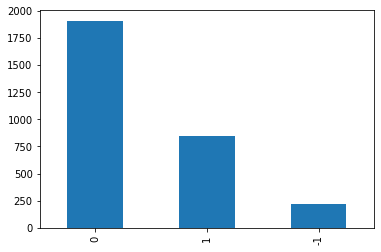

In [19]:
train_df = data_df.sample(n = int(len(data_df) * 0.8), random_state = 1030)
print ("number of training data",len(train_df))
train_df.polarity.value_counts().plot(kind = "bar")

number of training data 744


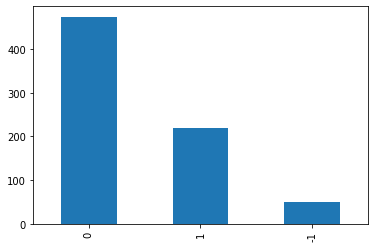

In [20]:
test_df = data_df[~data_df.index.isin(train_df.index.tolist())]
print ("number of training data",len(test_df))
test_df.polarity.value_counts().plot(kind = "bar")

In [21]:
set(test_df.index.unique())&set(train_df.index.unique())

set()

In [1]:
train_df.head()

NameError: name 'train_df' is not defined

In [26]:
train_df.text.apply(lambda x: len(x.split(" "))).describe()

count    2972.000000
mean       30.398385
std        14.208908
min         3.000000
25%        17.000000
50%        30.000000
75%        43.000000
max        62.000000
Name: text, dtype: float64

In [27]:
test_df.text.apply(lambda x: len(x.split(" "))).describe()

count    744.000000
mean      30.327957
std       14.419404
min        3.000000
25%       17.000000
50%       30.000000
75%       42.250000
max       62.000000
Name: text, dtype: float64

In [40]:
f = open("/ldap_home/yunrui.li/ABSA-PyTorch/datasets/headphone/headphone_train.txt", 'w')

for ix, row in train_df.iterrows():
    text = row.text.strip(" ")
    text = text.replace("\n", " ")
    text = text + " " +"$T$"
    aspect = row.aspect
    polarity = str(row.polarity)
    f.write(text)
    f.write("\n")
    f.write(aspect)
    f.write("\n")
    f.write(polarity)
    f.write("\n")
    
f.close()

In [41]:
f = open("/ldap_home/yunrui.li/ABSA-PyTorch/datasets/headphone/headphone_test.txt", 'w')

for ix, row in test_df.iterrows():
    text = row.text.strip(" ")
    text = text.replace("\n", " ")
    text = text + " " +"$T$"
    aspect = row.aspect
    polarity = str(row.polarity)
    f.write(text)
    f.write("\n")
    f.write(aspect)
    f.write("\n")
    f.write(polarity)
    f.write("\n")
    
f.close()

In [39]:
text[:-1] +" " + "$T$" + " " + text[-1:]

'Har använt mina lurar i snart en månad och är väldigt nöjd med ljudet tillsammans med min SONY Experia Mini $T$ .'